## Notebook #2: Modeling and Evaluation

In this notebook, we will walk through my modeling process and evaluation of my final model, a Random Forest Classifier. Through the modeling process, as I will show, I realized that using the raw question data was hurting my model performance. This seems to be due to the inpredictability of the patient questions. I decided that using the summarized questions instead would be better for modeling. While I don't have access to that model or code as I am working just within this second phase, I have access to the summarized question output. When I considered this issue further, I realized that it makes sense in production for raw data to be filtered through a summarizer before working through the classifier model. The summarizer here acts almost like a preprocesser for the data, and after redoing my model with the summarized data, it performed with much more accuracy. Because of this, the model became ready for production in a chat-based app. This journey will be discussed more indepth throughout this notebook.

--- 

First, I will walk through the modeling process of the raw data to show the issues I was presented with when I finished modeling.

In [212]:
import nltk
nltk.download('stopwords') # resource: https://pythonspot.com/nltk-stop-words/
stops = set(stopwords.words('english'))

import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pickle
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, f1_score, recall_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

[nltk_data] Downloading package stopwords to /Users/ER/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [213]:
le = LabelEncoder()
df_all['binary_pharm_1'] = pd.DataFrame(le.fit_transform(df_all['binary']), columns=['binary'])
df_all.head(3)  # labeling the target classes 

,00,000,000421,001274,00527172874,01,01d08e1e,01t11,02,03,...,zinc,zolmitriptan,zostavax,évidence,úlcera,ımportant,ınformatıon,ıs,binary,binary_pharm_1
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,pharmacist,1
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,pharmacist,1
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,pharmacist,1


In [214]:
X = df_all.drop(columns=['binary', 'binary_pharm_1'])
y = df_all['binary_pharm_1']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13, stratify=y)
y_train.value_counts(normalize=True) # null model - 86% predicting just internist for every observation

0    0.861333
1    0.138667
Name: binary_pharm_1, dtype: float64

Train Acc Score:  1.0
Test Acc Score:  0.904
Train F1 Score:  1.0
Test F1 Score:  0.5714285714285714


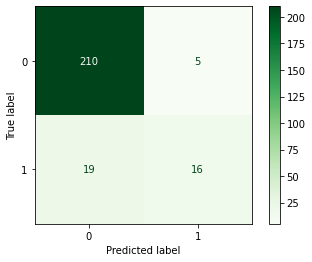

In [216]:
lg = LogisticRegression()
lg.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, lg.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, lg.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, lg.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, lg.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(lg, X_test, y_test, cmap='Greens');

My first model did not work very well on the test data - it was severely overfit. I am assuming this is due to the imbalance in my data. I will address this ad I continue to model below. 

In [217]:
over_sam = RandomOverSampler(random_state=13)
X_resampled, y_resampled = over_sam.fit_resample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=13, stratify=y_resampled)

Train Acc Score:  1.0
Test Acc Score:  0.9791183294663574
Train F1 Score:  1.0
Test F1 Score:  0.979498861047836


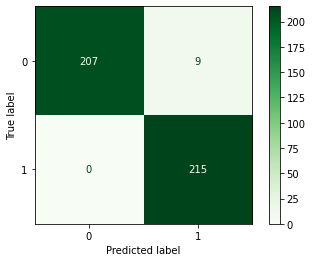

In [218]:
lg2 = LogisticRegression()
lg2.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, lg2.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, lg2.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, lg2.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, lg2.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(lg2, X_test, y_test, cmap='Greens');

In [219]:
lg2.coef_

array([[ 0.0762698 , -0.14033299, -0.00251424, ..., -0.00171164,
        -0.00171164, -0.00342328]])

In [220]:
conv_odds = pd.DataFrame(np.exp(lg2.coef_[0]), index=lg2.feature_names_in_, columns = ['coef_val'])
conv_odds.sort_values(by='coef_val', ascending=True).head(25)  # top 25 for internist class 

,coef_val
problem,0.420707
disease,0.447977
would,0.461988
shingles,0.475530
back,0.503301
syndrome,0.515610
ago,0.525386
get,0.536916
cause,0.545309
surgery,0.545650


The second round of Logistic Regression worked quite well. However, I want to see if I can get a model to fit even closer to 100% on train and test. Before I move on, I wanted to also look at the influential words associated with each target class. When working with Logistic Regression coefficients in this way (inversing them with np.exp), I can look to see where they fall from 0 to 1 (or whatever the highest number turns out to be). In this case, the words with coefficients closer to 0 are more influential for the internist target class, and those with higher coefficients are more influential for the pharmacist target class. 

By looking at the words above and below in relation to their target classes, it appears as though our initial EDA was correct in that patients asking for internists are interested in diseases, their treatment, syndromes, the causes of syndromes, and specific named issues like strokes, hormones, hernias, etc. They are seeking knowledge about diagnoses in general. Compared to that of the pharmacist class below, they are seeking out knowledge related to specific medicaitons/drugs, dosages, how the drugs are to be taken (instructions), pharmacies, and ingredients. Several forms of the word medication (medication, meds, drugs) are used to refer to their subject. Words like lower and build can refer to the mechanism of action for these drugs (how they work). 

In [221]:
conv_odds.sort_values(by='coef_val', ascending=True).tail(25)  # top 25 for pharmacist class

,coef_val
used,2.056468
gabapentin,2.090093
glucosamine,2.098635
drugs,2.106200
cetirizine,2.107598
dosage,2.108786
system,2.159103
instructions,2.210500
march,2.227311
lower,2.282762


Train Acc Score:  0.9279628195197521
Test Acc Score:  0.8677494199535963
Train F1 Score:  0.9304412864622289
Test F1 Score:  0.8763557483731019


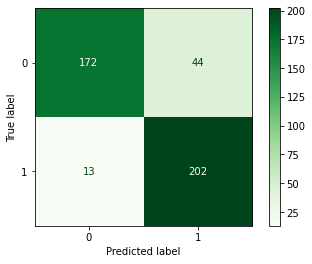

In [222]:
gbc = GradientBoostingClassifier(n_estimators=50)  # trying out Gradient Boost, but it didn't work as well as LG2
gbc.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, gbc.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, gbc.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, gbc.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, gbc.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(gbc, X_test, y_test, cmap='Greens');

Train Acc Score:  1.0
Test Acc Score:  0.988399071925754
Train F1 Score:  1.0
Test F1 Score:  0.9885057471264368


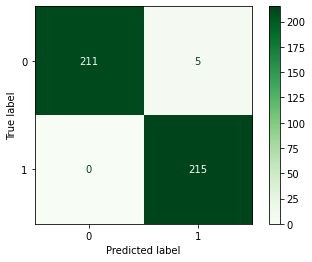

In [223]:
rfc = RandomForestClassifier(n_jobs=-1)
rfc.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, rfc.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, rfc.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, rfc.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, rfc.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(rfc, X_test, y_test, cmap='Greens');

Ultimately, the Random Forest Classifier appears to be the best model for my data. I believe an accuracy of 98.8% on the test data is as close as I will get to perfect, with only 5 miscassifications. I would like to dive deeper into this and GridSearch to see if there are better parameters than default.

In [225]:
rfc2_params = {
    'n_estimators' : [10, 50, 100, 150],
    'min_samples_split' : [2, 3, 4],
    'max_depth' : [None, 3, 4, 5]
}

rfc2 = RandomForestClassifier()
# default= estimators,100; min split,2; max depth,None 

gs = GridSearchCV(rfc2, rfc2_params, n_jobs=-1)
gs.fit(X_train, y_train)
gs.best_estimator_

print(f'Train Acc Score: ', accuracy_score(y_train, gs.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, gs.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, gs.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, gs.predict(X_test)))

Train Acc Score:  1.0
Test Acc Score:  0.9860788863109049
Train F1 Score:  1.0
Test F1 Score:  0.9862385321100917


Surprisingly, the best estimator settings for Random Forest classify slightly worse than the default settings (only by .02). I am definitely satisified with this finding and will move forward with the default settings for Random Forest. Next, I will set up the data to feed through a pipeline that will vectorize and classify the data. This will allow me to feed questions through the model as a way to test its functionality and prepare it for production. 

---

In [ ]:
le2 = LabelEncoder()  # encoding target class for this dataframe
df_vec['binary_dummy'] = pd.DataFrame(le2.fit_transform(df_vec['binary']), columns=['binary'])
df_vec.drop(columns=['binary'], inplace=True)
df_vec.head(3)  # cannot run cell again as column is already made

,message,binary_dummy
0,SUBJECT: who and where to get cetirizine - D\n MESSAGE: I need/want to know who manufscturs Cetirizine. My Walmart is looking for a new supply and are not getting the recent,1
1,"who makes bromocriptine\n i am wondering what company makes the drug bromocriptine, i need it for a mass i have on my pituitary gland and the cost just keeps raising. i cannot ever buy a full prescription because of the price and i was told if i get a hold of the maker of the drug sometimes they offer coupons or something to help me afford the medicine. if i buy 10 pills in which i have to take 2 times a day it costs me 78.00. and that is how i have to buy them. thanks.",1
2,"SUBJECT: nulytely\n MESSAGE: Hello can you tell me where do i order the nulytely who is the manufacture, what phone number can i call. thanks.",1


In [229]:
X = df_vec[['message']]
y = df_vec['binary_dummy']

over_sam = RandomOverSampler(random_state=13)  # oversampling to balance data
X_resampled, y_resampled = over_sam.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled['message'], y_resampled, random_state=13, stratify=y_resampled)   
# used X_resampled['message'] to make it a series so it would work with the pipeline

Train Acc Score:  1.0
Test Acc Score:  0.9860788863109049
Train F1 Score:  1.0
Test F1 Score:  0.9862385321100917


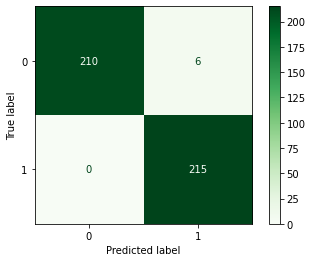

In [230]:
pipe = Pipeline([
    ('cv2', CountVectorizer(stop_words=stops)),
    ('rfc3', RandomForestClassifier(n_jobs=-1))
])

pipe.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, pipe.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, pipe.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, pipe.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, pipe.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(pipe, X_test, y_test, cmap='Greens');

In [231]:
pipe.predict(['Can I store my medication in the freezer or will that reduce their efficacy?'])

array([0])

In [232]:
pipe.predict(['What dose of my medicine should i take in the mornings? who manufactures this medication?'])

array([0])

This is where I started having issues and concerns about my model. Both of the above predictions should return pharmacist class, but it is returning internist. Both of the questions above include influential words from the Logistic Regression model as well as frequently used words identified in the initial EDA. Because I was confused by this, I worked through a few other models from above within pipelines to see if the issue persisted.

Train Acc Score:  1.0
Test Acc Score:  0.9791183294663574
Train F1 Score:  1.0
Test F1 Score:  0.979498861047836


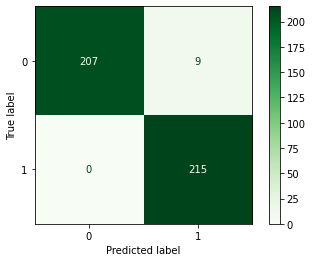

In [233]:
pipe2 = Pipeline([
    ('cv2', CountVectorizer(stop_words=stops)),
    ('lg3', LogisticRegression(n_jobs=-1))
])

pipe2.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, pipe2.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, pipe2.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, pipe2.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, pipe2.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(pipe2, X_test, y_test, cmap='Greens');

In [234]:
pipe2.predict(['Will storing my medication in the freezer reduce their efficacy?'])

array([0])

In [235]:
pipe2.predict(['What dose of my medicine should i take in the mornings? who manufactures this medication?'])  # issue persists with LG2

array([0])

Train Acc Score:  0.9635941130906274
Test Acc Score:  0.9234338747099768
Train F1 Score:  0.9646882043576259
Test F1 Score:  0.9277899343544859


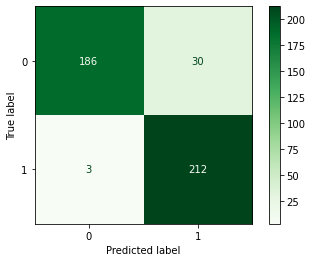

In [236]:
pipe3 = Pipeline([
    ('cv2', CountVectorizer(stop_words=stops)),
    ('gbc', GradientBoostingClassifier())
])

pipe3.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, pipe3.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, pipe3.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, pipe3.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, pipe3.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(pipe3, X_test, y_test, cmap='Greens');

In [237]:
pipe3.predict(['Will storing my medication in the freezer reduce their efficacy?'])  # issue persists with GBC

array([0])

In [238]:
pipe3.predict(['What dose of my medicine should i take in the mornings? who manufactures this medication?'])

array([0])

It was at this point that I was getting very confused as to why the predictions were not classifying correctly despite great accuracy and F1 scores. I pulled a dataframe together of the predictions, messages, and dummified target class to see my misclassifications.

In [239]:
X_test.index = pd.DataFrame(pipe.predict(X_test)).index  # resource: https://stackoverflow.com/questions/40339886/pandas-concat-generates-nan-values --> need to set indexes equal to concat on them
eval_df = pd.concat([X_test, pd.DataFrame(pipe.predict(X_test), columns=['preds'])], axis=1)

eval_df.index = pd.DataFrame(y_test).index  # equaling indexes to concat
eval_df = pd.concat([eval_df, pd.DataFrame(y_test)], axis=1)

eval_df.head(3)

,message,preds,binary_dummy
1654,"SUBJECT: fluticasone\n MESSAGE: I was prescribed this med for rhinitis, I used it as directed, when it ran out I stopped, that was only 7 days ago. Now, I have an awful upper respiratory infection. Could halting Fluticasone have possibly caused this?? How long is person supposed to be taking Fluticasone?",1,1
870,MESSAGE: Sir .my problem based on nerves ..my sister legs nerves tried each other how i can treat,0,0
746,"MESSAGE: I would like to thank you for the valuable information on the subject. I am suffering from acute pain in my right knee for the last two years. I had undergone several treatment in Allopathy, Ayurveda, Homeopathy, Acu-Puncture, Physio-Therapy etc. But the results have been slow. I would be happy if you can suggest me some idea to get over the problem. I am 61 years old. The orthopaedician I consulted, advised me to go for an MRI scan and he told me that I should undergo a surgery. Many people advised me against it considering my age. What is your advice?",0,0


In [240]:
eval_df[eval_df['preds'] != eval_df['binary_dummy']]  # shows the misclassified messages sent through the initial pipeline that used RFC (my best model)

,message,preds,binary_dummy
562,SUBJECT: vaginal rashes after periods that leads to vaginal itching\n MESSAGE: period rashes proceed to vaginal itching. then it develop fungal infection with thick white discharge. i then take flucanazole (antifungal)which cure it. but m worried of taking allopatic medicines. pls tell me what primitive or traditional methods do i use to avoid it. i also have a sensitive skin.,1,0
87,SUBJECT: SEVERE leg cramps with Lupus\n MESSAGE: My wife has Systemic Lupus and is already taking Potassium Chloride 20meg er 1QD and about 24-48 ounces of Gatoraid every day but still gets SEVERE leg cramps. What can she do to stop or help stop the cramps?,1,0
86,SUBJECT: adema\n MESSAGE: I have adema in my ankles/shins. What can I do to lesson the severity of the adema ( I take bp meds w/ diaretic) ?,1,0
782,"SUBJECT: GERD\n MESSAGE: in reviewing some meds that treat GERD, i dont see much difference between Prilosec,Nexium,Tagament and Zantac. It is said that Prilosec and Nexium are proton pump inhibitors and Zantac and Tagamet H2 blockers. Their definitions of action are the the same that they reduce the amount of stomach acid.Are their really any big differences in these 4 medicnes?",1,0
726,SUBJECT: blocked ear drum\n MESSAGE: got a head cold and now left ear drum has bean blocked for three weeks now.taking amoxicillin trihydrate three times a day also apo-mometasone spray once a day. its bean five days now on medication and not any better,1,0
218,SUBJECT: safe cold medicine to take with Graves disease\n MESSAGE: I have a runny nose and headache and have Graves. What is a safe cold medicine to take over the counter?,1,0


From these misclassifications, I can see that the issue lies potentially with the nature of the questions and data themselves. It was here that I realized the data needs to be preprocessed before it would be ready for classification. Because of this, I decided to work with the summarized questions instead of the raw question data. In production, this will present as the chat feature pulling in the question from the patient, putting it through the summarizer as a step in preprocessing, and then filtering it through my classification model to finally direct it to a specialist. Let's work with the new data below. Because the code and model are not available for the summarizer the initial phase used, I will be using the summarized data only.

---

In [176]:
df_sum = questions[['Summary', 'binary']]  # preparing dataset for modeling
le3 = LabelEncoder()
df_sum['binary_dummy'] = pd.DataFrame(le3.fit_transform(df_sum['binary']), columns=['binary'])  # encoding target class
df_sum.drop(columns=['binary'], inplace=True)
df_sum.head(3)

/var/folders/3x/mhg15qwn5vs8792nlh38tg080000gn/T/ipykernel_27617/2189746953.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Summary,binary,binary_dummy
0,Who manufactures cetirizine?,pharmacist,1
1,Who manufactures bromocriptine?,pharmacist,1
2,"Who makes nulytely, and where can I buy it?",pharmacist,1


In [242]:
X = df_sum[['Summary']]
y = df_sum['binary_dummy']

over_sam = RandomOverSampler(random_state=13) # oversampling to balance
X_resampled, y_resampled = over_sam.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled['Summary'], y_resampled, random_state=13, stratify=y_resampled)   

Train Acc Score:  1.0
Test Acc Score:  0.9837587006960556
Train F1 Score:  1.0
Test F1 Score:  0.9839816933638443
Train Sensitivity Score:  1.0
Test Sensitivity Score:  1.0


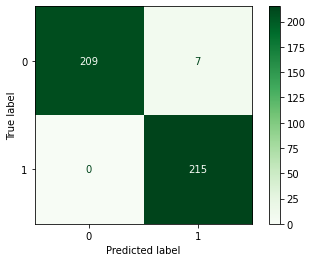

In [243]:
pipe4 = Pipeline([
    ('cv3', CountVectorizer(stop_words=stops)),
    ('rfc4', RandomForestClassifier(n_jobs=-1))
])

pipe4.fit(X_train, y_train)

print(f'Train Acc Score: ', accuracy_score(y_train, pipe4.predict(X_train)))
print(f'Test Acc Score: ', accuracy_score(y_test, pipe4.predict(X_test)))
print(f'Train F1 Score: ', f1_score(y_train, pipe4.predict(X_train)))
print(f'Test F1 Score: ', f1_score(y_test, pipe4.predict(X_test)))

print(f'Train Sensitivity Score: ', recall_score(y_train, pipe4.predict(X_train)))
print(f'Test Sensitivity Score: ', recall_score(y_test, pipe4.predict(X_test)))

ConfusionMatrixDisplay.from_estimator(pipe4, X_test, y_test, cmap='Greens');

As I can see from model performance above, the model works great. It is only very slightly worse than the initial model, but still predicts with 98.3% accuracy on the test data. This is sufficient for me.

In [244]:
pipe4.predict(['Will storing my medication in the freezer reduce their efficacy?'])

array([1])

In [245]:
pipe4.predict(['I want to see what kind of gelatin is used in vitamin d. is it from pork?'])

array([1])

In [246]:
pipe4.predict(['What dose of my medicine should i take in the mornings? who manufactures this medication?'])

array([1])

In [247]:
pipe4.predict(['I cant afford the brand name albuterol product. What are some generic versions of this medication'])

array([1])

In [248]:
pipe4.predict(['I hit my leg on the coffee table corner. I have a bruise. Am I dying?'])

array([0])

In [249]:
pipe4.predict(['What are the symptoms of a heart attack?'])

array([0])

The best part about this is that the model is far more accurate when submitting predictions through the pipeline and predicts with about the same accuracy score. Therefore, this is the model that I need to have a successful product. I particularly think Random Forest works so well because it uses the randomization and de-correlating to reduce the high variance issues we saw with other models like Logistic Regression. Because the F1 and sensitivity scores are also very good, I am deeming this model ready for application. 

When considering real-time use of this product, I am concerned that patients who need immediate treatment but may not know might ask questions seeking help or explanation. I think it would be important to include a disclaimer in or near the chat feature that tells the patient symptoms that need emergent attention and to call 911 instead of using the chat feature. This product should be for explanation and knowledge assistance. Any patient seeking immediate medical care needs to know that they will not find it here. 

In [208]:
with open('rfc-pipe-model.pkl', 'wb') as file:  # saved model for Streamlit example
    pickle.dump(pipe4, file)

--- 

### Failed Topic Analysis: 

Below is code from trying out a topic analysis on this data. As we can see below, the topic analysis did not find much of anything to be useful. I consider this to have failed and did not use it for further analysis.

In [88]:
from bertopic import BERTopic

In [100]:
topic_model = BERTopic()
topic_model

In [101]:
pharm_docs = df_vec['message'][df_vec['binary'] == 'pharmacist'].to_list()

In [102]:
topics, probabilities = topic_model.fit_transform(pharm_docs)

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [109]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,60,-1_the_to_is_and
1,0,37,0_the_to_message_it
2,1,28,1_gluten_you_message_free
3,2,14,2_the_for_my_to


In [108]:
topic_model.get_topic(2)

[('the', 0.07138237813999879),
 ('for', 0.06707208486870866),
 ('my', 0.06529622157834708),
 ('to', 0.058894377683164974),
 ('and', 0.056876593780870725),
 ('has', 0.050496536152533654),
 ('message', 0.049692260623696756),
 ('is', 0.04766718645390927),
 ('subject', 0.046765835859943435),
 ('of', 0.04596120874716621)]

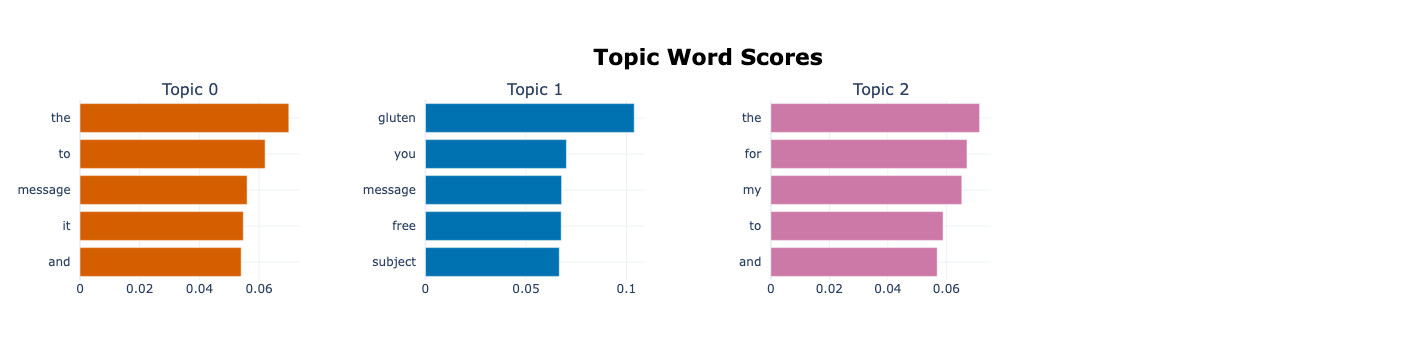

In [110]:
topic_model.visualize_barchart()

In [111]:
topic_model2 = BERTopic()
topic_model2

In [112]:
intern_docs = df_vec['message'][df_vec['binary'] == 'internist'].to_list()

In [114]:
topics, probabilities = topic_model2.fit_transform(intern_docs)

/opt/anaconda3/envs/capstone/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



In [116]:
topic_model2.get_topic_info()

,Topic,Count,Name
0,0,843,0_to_the_and_my
1,1,18,1_ear_hearing_and_in


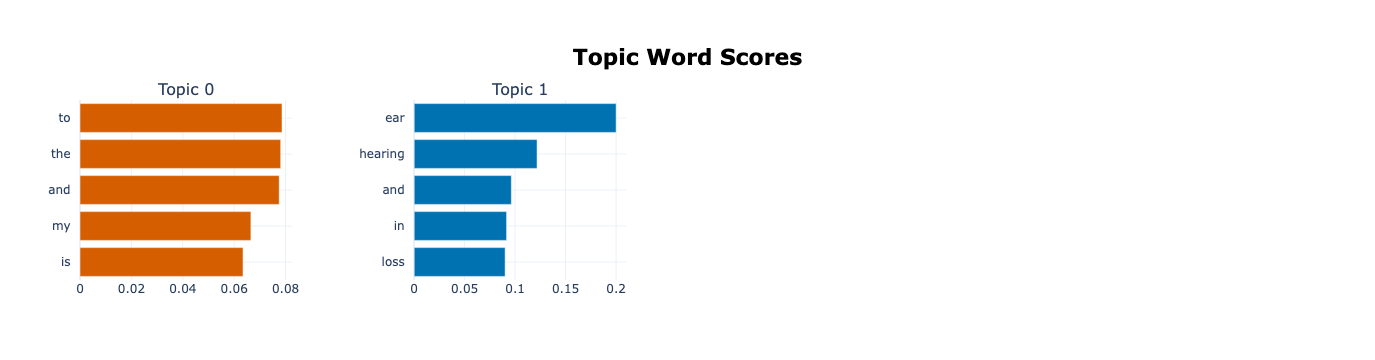

In [118]:
topic_model2.visualize_barchart()

---